# Introduction

Here we describe our analysis of the wikipedia traffic data.

# Imports

In [74]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

In [2]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [3]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [4]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Page Features

## Breaking Up Page Data

Now we break up the Page data into the name of the page, the wikipedia project, the access, and the agent. We store these features in a separate dataframe, page_df.

In [5]:
# Let's get information from Page data.

urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in data_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

page_df = pd.DataFrame(data = pageInfo[0], columns = ['name'])

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    page_df[name] = infoCol

page_df.head()

,name,project,access,agent
0,2NE1,9,0,3
1,2PM,9,0,3
2,3C,9,0,3
3,4minute,9,0,3
4,52_Hz_I_Love_You,9,0,3


To get a rough idea of how features extracted from the name affect our predictions, for each sample we will make use of ratios of the mean target value of visits over the mean value of visits in the domain. Now, we will need to make predictions for 62 days worth of data, so we treat the last 62 days in our time series of visits as target data.

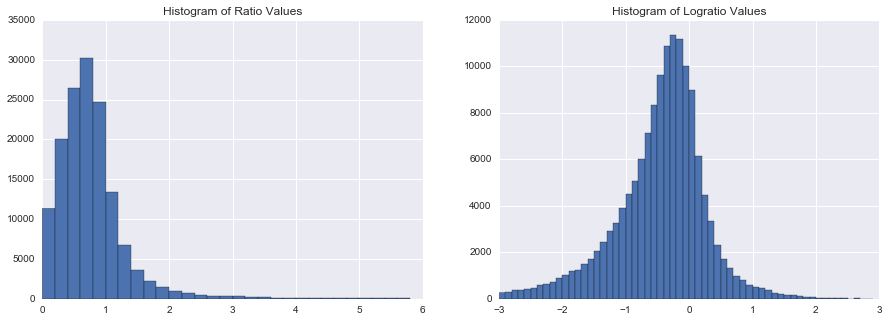

In [6]:
# Get the ratios of the means.

futureT = 62
epsilon = 1e-6

X_means = data_df.drop(['Page'], axis = 1).values[:, :-futureT].mean(axis = 1)
Y_means = data_df.drop(['Page'], axis = 1).values[:, -futureT:].mean(axis = 1)
ratios = Y_means / (epsilon + X_means)
page_df['ratios'] = ratios
page_df['logratios'] = np.log(epsilon + ratios)

doublefigsize = (15, 5)
plt.figure(figsize = doublefigsize)
plt.subplot('121')
page_df.ratios.hist(bins = np.arange(0, 6, 0.2))
plt.title('Histogram of Ratio Values')
plt.subplot('122')
page_df.logratios.hist(bins = np.arange(-3, 3, 0.1))
plt.title('Histogram of Logratio Values')
plt.show()

The histogram of ratio values is lop sided. We tried to fix it above by using the logarithm of the ratios. However, we see that the simple logarithm now has a tail on the left hand side. However, when we transform our ratios, it isn't necessarily best to transform the distribution into one resembling a Gaussian. Consider picking a value x to use as a prediction for a Gaussian distribution. For L2 regression, the optimal x to choose is the mean. However, for SMAPE, the optimal prediction should be below the median (which is the mean) since smape prefers over predictions to under predictions.

Let's us try to find a shift parameter such that the inverse transform of the mean value of the transformed distribution of Y_means is optimal for SMAPE score. This value should be related to optimizing smape score for L2 regression.

First let's see how the mean does as a predictor for the Y vals.

In [7]:
Y_vals = data_df.drop('Page', axis = 1).values[:, -futureT:]
Y_means = Y_vals.mean()
Y_means = np.full(Y_vals.shape, Y_means)
newsmape = smape(Y_vals, epsilon + Y_means)
print('Smape of just mean = ', newsmape)

Smape of just mean =  139.15566178


Now do a search over the optimal parameter param for a transformation z = np.log(param + y).

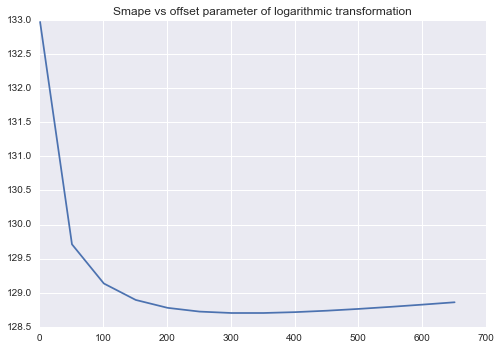

In [8]:
search = np.arange(1, 700, 50)

smapes = []
for param in search:
    Z_vals = np.log(param + Y_vals)
    Z_means = Z_vals.mean()
    Y_means = np.full(Y_vals.shape, -param + np.exp(Z_means))
    newsmape = smape(epsilon + Y_means, Y_vals)
    smapes.append(newsmape)
    
plt.plot(search, smapes)
plt.title('Smape vs offset parameter of logarithmic transformation')
plt.show()

So let's use the transform z = np.log(300 + y).

However, if we try training on the ratios of the Y vals to the mean of the X values, then we will need to use a different offset on the logarithm transformation.

Let's do a quick test of the smape for the Y_vals when predicting the ratio.

In [9]:
ratio_mean = page_df.ratios.mean()
Y_predict = (ratio_mean * X_means).reshape(-1, 1)
Y_predict = np.full(Y_vals.shape, Y_predict)
newsmape = smape(epsilon + Y_predict, Y_vals)
print('For simple ratio mean prediction, smape = ', newsmape)

For simple ratio mean prediction, smape =  81.3577548033


Now let's look at an offset search on logarithmic transformation of ratios.

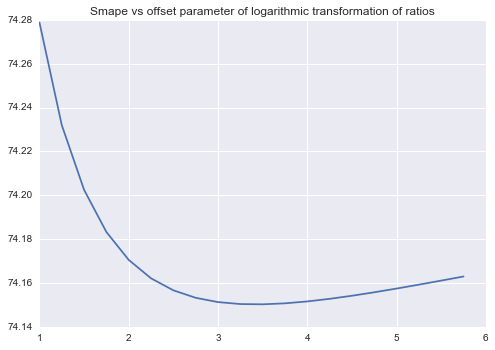

In [10]:
search = np.arange(1, 6, 0.25)

smapes = []
for param in search:
    Z_vals = np.log(param + page_df.ratios.values)
    Z_means = Z_vals.mean()
    ratio_predict = -param + np.exp(Z_means)
    Y_predict = (X_means * ratio_predict).reshape(-1,1)
    Y_predict = np.full(Y_vals.shape, Y_predict)
    newsmape = smape(epsilon + Y_predict, Y_vals)
    smapes.append(newsmape)
    
plt.plot(search, smapes)
plt.title('Smape vs offset parameter of logarithmic transformation of ratios')
plt.show()

So we see that the optimal constant to choose is about 3.5. So we go with z = np.log( 3.5 + Ratio ).

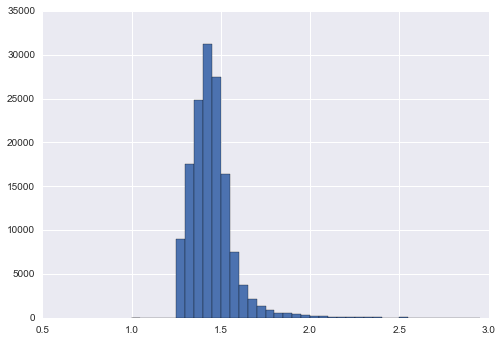

In [11]:
page_df.logratios = np.log(3.5 + page_df.ratios)

page_df.logratios.hist(bins = np.arange(1.0, 3, 0.05))
plt.show()

## Name Features

Now we look at creating features from the names.

### Number of Words in Name

Let's count the number of words in each name by counting the number of appearances of the character '_'.

In [12]:
# Let's count number of words in name.

numWords = []

for name in page_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)

page_df['numWords'] = numWords

Let's look at a histogram of word counts and how mean of log ratios depends on word counts.

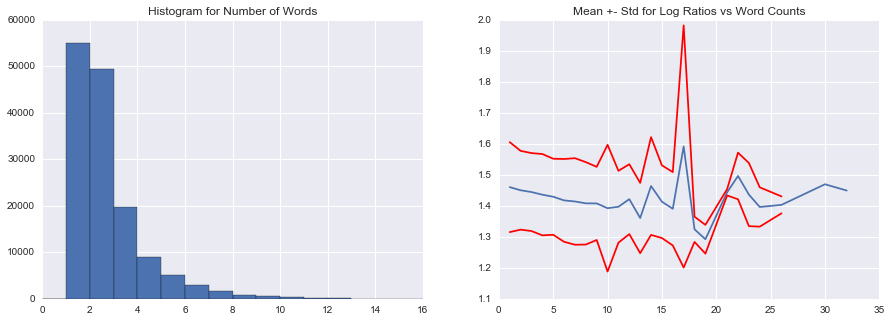

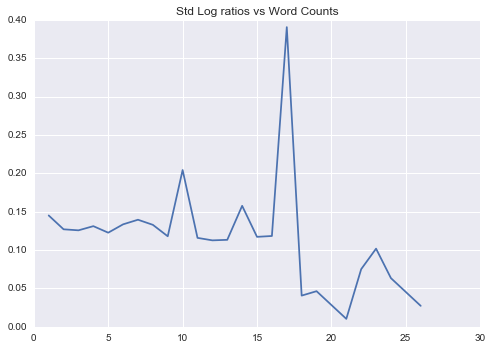

In [13]:
# Let's look at statistics for number of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df['numWords'].hist(bins = np.arange(17))
plt.title('Histogram for Number of Words')

grouped_mean = page_df.groupby('numWords').mean()
grouped_std = page_df.groupby('numWords').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Word Counts')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Word Counts')
plt.show()

### Counts of Numbers in Name

Now let's look at counting the numbers that occur in each name.

In [14]:
# Let's look at number of Numbers.

numNums = []
for name in page_df['name']:
    num = len(re.split(r'\d+', name))
    numNums.append(num)
        
numNums = np.array(numNums)

page_df['numNums'] = numNums

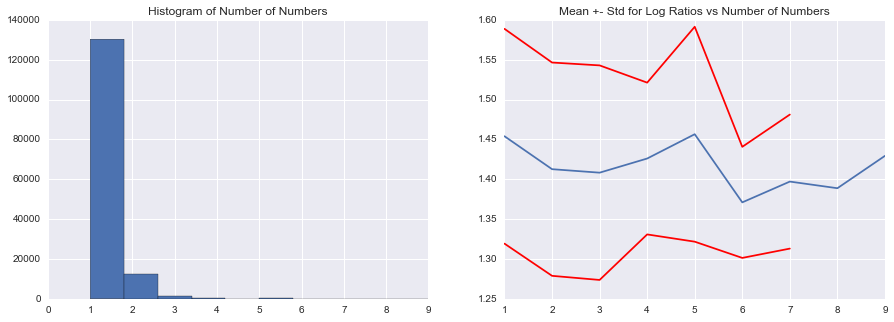

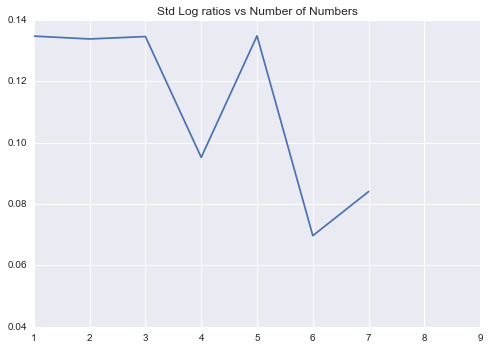

In [15]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numNums.hist()
plt.title('Histogram of Number of Numbers')

grouped_mean = page_df.groupby('numNums').mean()
grouped_std = page_df.groupby('numNums').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Number of Numbers')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Number of Numbers')
plt.show()

### Size of First Number in Name

Now we extract the first number that appears in the name. We keep track of its size (i.e. itself).

In [16]:
# Let's get size of numbers inside names.

numSize = []
matches = []
for name in page_df['name']:
    match = re.search(r'\d+', name)
    matches.append(match)
    if match != None:
        num = float(match.group())
    else:
        num = 0
    numSize.append(num)

page_df['numSize'] = numSize

We look at a histogram of the positive numbers. We then adjust these values into two categories.

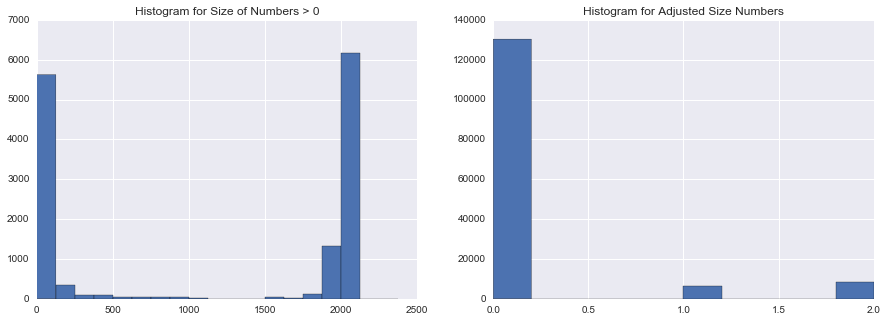

Proportion of Ajusted Number Size == 1 is  0.0437809779199
Proportion of Ajusted Number Size == 2 is  0.0579058753783
Mean Log Ratios by Adjusted Number Size
numSize2
0.0    1.453924
1.0    1.431765
2.0    1.398813
Name: logratios, dtype: float64


In [17]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numSize.hist(bins = np.arange(1, 2.5e3, 2.5e3 / 20))
plt.title('Histogram for Size of Numbers > 0')


page_df['numSize2'] = page_df.numSize
mask = page_df.numSize2 > 0
page_df.loc[mask & (page_df.numSize2 < 1250), 'numSize2'] = 1
page_df.loc[mask & (page_df.numSize2 > 1), 'numSize2'] = 2

plt.subplot(122)
page_df.numSize2.hist()
plt.title('Histogram for Adjusted Size Numbers')
plt.show()

print('Proportion of Ajusted Number Size == 1 is ', np.sum(page_df.numSize2 == 1) / len(page_df.numSize2))
print('Proportion of Ajusted Number Size == 2 is ', np.sum(page_df.numSize2 == 2) / len(page_df.numSize2))

print('Mean Log Ratios by Adjusted Number Size')
print(page_df.groupby('numSize2').mean().logratios)

### Acronym Count

Let's count the number of capital letters that occur in a sequence of two or more capital letters. This roughly gives a count of the number of letters that occur in acronyms.

In [18]:
# Let's look at number of consecutive capital letters (like in an acronym).

capNums = []
matches = []
for name in page_df['name']:
    match = re.findall(r'[A-Z][A-Z]+', name)
    matches.append(match)
    num = 0
    for s in match:
        num += len(s)
    capNums.append(num)
    
page_df['capNums'] = capNums

page_df.loc[[0, 4, 6, 8], ['name', 'capNums']]

,name,capNums
0,2NE1,2
4,52_Hz_I_Love_You,0
6,91Days,0
8,AKB48,3


Proportion with Acronym Count > 0 =  0.0506814280692


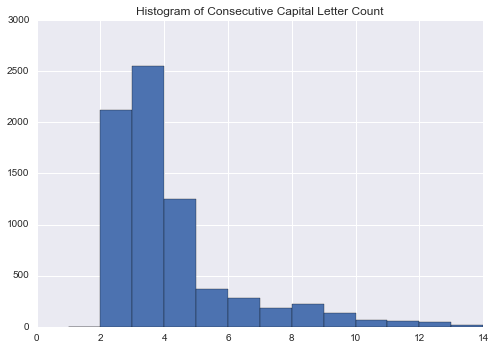

In [19]:
print('Proportion with Acronym Count > 0 = ', np.sum(page_df.capNums > 0) / len(page_df.capNums))

page_df.capNums.hist(bins = np.arange(1, 15))
plt.title('Histogram of Consecutive Capital Letter Count')
plt.show()

### Largest Word Length

In [20]:
# Let's look at largest word length

wordLengths = []
for name in page_df['name']:
    words = re.split(r'_|\d+', name)
    matches.append(match)
    if words:
        lengths = np.array([len(x) for x in words])
        wordLengths.append(np.amax(lengths))
    else:
        wordLengths.append(0)
    
# put into data frame

page_df['wordLength'] = wordLengths
page_df.loc[[0, 4, 6, 8], ['name', 'wordLength']]

,name,wordLength
0,2NE1,2
4,52_Hz_I_Love_You,4
6,91Days,4
8,AKB48,3


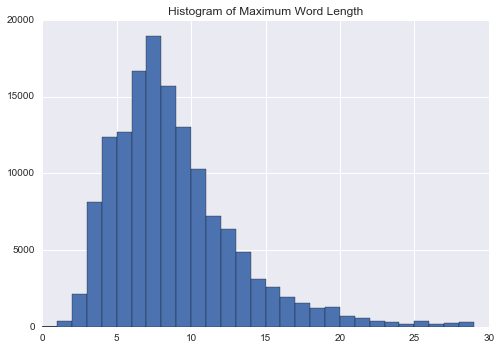

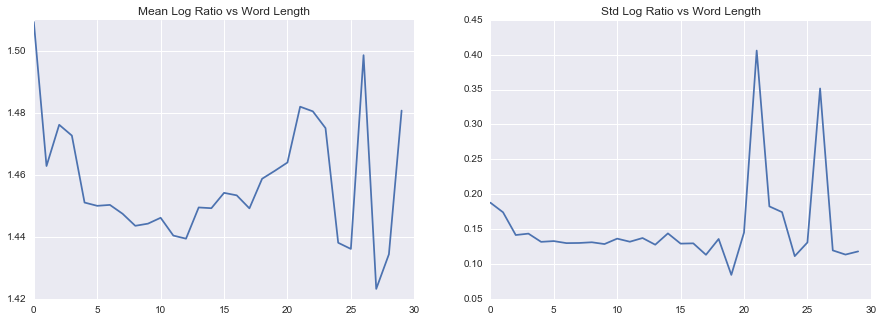

In [21]:
page_df.wordLength.hist(bins = np.arange(30))
plt.title('Histogram of Maximum Word Length')
plt.show()

grouped_name = page_df[page_df.wordLength < 30].groupby('wordLength')
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(grouped_name.mean().index, grouped_name.mean().logratios)
plt.title('Mean Log Ratio vs Word Length')

plt.subplot(122)
plt.plot(grouped_name.std().index, grouped_name.std().logratios)
plt.title('Std Log Ratio vs Word Length')
plt.show()

### Collect Name Features

In [22]:
page_df.head()

,name,project,access,agent,ratios,logratios,numWords,numNums,numSize,numSize2,capNums,wordLength
0,2NE1,9,0,3,1.049298,1.514973,1,3,2.0,1.0,2,2
1,2PM,9,0,3,1.309217,1.570534,1,2,2.0,1.0,2,2
2,3C,9,0,3,1.009199,1.506120,1,2,3.0,1.0,0,1
3,4minute,9,0,3,0.943928,1.491539,1,2,4.0,1.0,0,6
4,52_Hz_I_Love_You,9,0,3,1.178455,1.542968,5,2,52.0,1.0,0,4


In [23]:
name_features = ['project', 'access', 'agent', 'numWords', 'numNums', 'numSize2', 'capNums', 'wordLength']
nameFeatures = page_df[name_features].values

# Divide Data into Training and Validation

In [24]:
timeSeries = data_df.drop(['Page'], axis = 1).values

In [25]:
# Now get data for training and validation.

nSamples, nName = nameFeatures.shape

X_all = timeSeries[:, :-futureT]
X_all = np.hstack((nameFeatures, X_all))
Y_all = timeSeries[:, -futureT:]

In [26]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
print('X_train.shape = ', X_train.shape, '\tY_train.shape = ', Y_train.shape, 
      '\tX_valid.shape = ', X_valid.shape, '\tY_valid.shape = ', Y_valid.shape)

X_train.shape =  (97192, 739) 	Y_train.shape =  (97192, 62) 	X_valid.shape =  (47871, 739) 	Y_valid.shape =  (47871, 62)


# Simple Name Features Models

## Benchmark of No Name Features

1   136.00 	4   128.09 	7   91.88 	10   75.53 	13   73.62 	16   74.36 	19   76.27 	



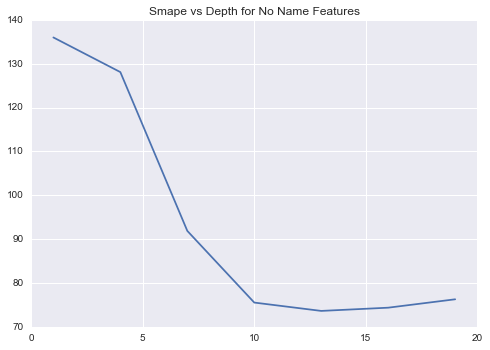

Best depth and smapes are:


,depth,smape
3,10.0,75.526828
4,13.0,73.623099
5,16.0,74.361171
6,19.0,76.274097


In [124]:
# Simply use the time series mean. This is a benchmark for no name features.

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])

model = Pipeline([ ('data', timeTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(1, 20, 3)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns
for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for No Name Features')
plt.show()

results_df = pd.DataFrame(np.stack([search, smapes], axis = -1), 
                          columns = ['depth', 'smape'])
print('Best depth and smapes are:')
results_df[results_df.smape < 80]

In [125]:
# Let's record the best result for this model.

best_df = pd.DataFrame( [ [results_df.depth[4], results_df.smape[4]] ],
                     columns = ['depth', 'smape'],
                     index = ['JustMean'])
best_df

,depth,smape
JustMean,13.0,73.623099


## Mean and Name Features

7   91.92 	9   77.41 	11   73.84 	13   72.24 	15   71.98 	17   71.94 	19   72.93 	

21   74.60 	23   77.11 	

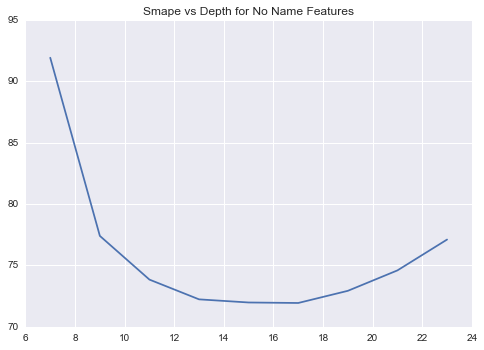

Best depth and smapes are:


,depth,smape
2,11.0,73.844540
3,13.0,72.235912
4,15.0,71.980300
5,17.0,71.940333
6,19.0,72.931164
7,21.0,74.595370


In [126]:
# Simply use the time series mean and the name features.

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])
nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(7, 25, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for No Name Features')
plt.show()

results_df = pd.DataFrame(np.stack([search, smapes], axis = -1), 
                          columns = ['depth', 'smape'])
print('Best depth and smapes are:')
results_df[results_df.smape < 75]

In [131]:
# Let's record the best smape

best_df.loc['NameAndMean'] = [results_df.depth[4], results_df.smape[4]]

# Let's look at the improvement in smape.

improve = best_df.loc['JustMean', 'smape'] - best_df.loc['NameAndMean', 'smape']
improve = np.abs(improve) / best_df.loc['JustMean', 'smape']
print('Proportion of improvement since last model is ', '%.3f' % improve)

best_df

Proportion of improvement since last model is  0.022


,depth,smape
JustMean,13.0,73.623099
NameAndMean,15.0,71.980300


## Name Features and Log Transformation of X and Y

1   110.45 	4   73.29 	7   67.87 	10   66.39 	13   67.38 	16   70.43 	19   75.39 	



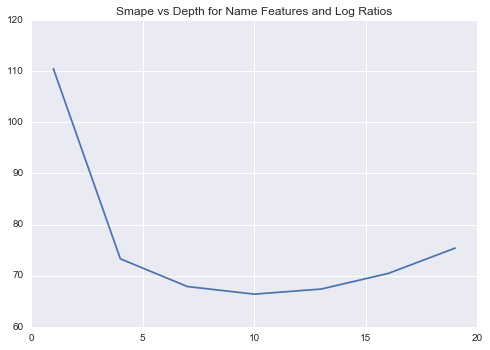

Best depth and smapes are:


,depth,smape
2,7.0,67.873953
3,10.0,66.385551
4,13.0,67.381733


In [132]:
# Simply use the time series mean. This is a benchmark for no name features.

param = 300

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(1, 20, 3)

Z_train = np.log(param + Y_train)
Z_valid = np.log(param + Y_valid)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for Name Features and Log Ratios')
plt.show()

results_df = pd.DataFrame(np.stack([search, smapes], axis = -1),
                          columns = ['depth', 'smape'])
print('Best depth and smapes are:')
results_df[results_df.smape < 70]

In [135]:
best_df.loc['logTransform'] = [results_df.depth[3], results_df.smape[3]]

improve = best_df.loc['logTransform', 'smape'] - best_df.loc['NameAndMean', 'smape']
improve = np.abs(improve) / best_df.loc['NameAndMean', 'smape']
print('Proportion of improvement from previous model is ', '%.3f' % improve)

best_df

Proportion of improvement from previous model is  0.078


,depth,smape
JustMean,13.0,73.623099
NameAndMean,15.0,71.980300
logTransform,10.0,66.385551


# Simple Window Mean Model

Now we consider adding features based on taking the mean inside windows of time, which should be located as close to the last time as possible. Note that we will keep the entire mean of all of the data, so we do not use windows covering the entire time domain. This is due to the fact that in such a case, the entire mean will have to be a specific average of these window means; so there will be a definite linear relationship between our features in this case.

In [139]:
# Function for computing the window means. We specify the number of windows and every window has the same window size.

def window_means(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    cols = np.arange(windowSize)[:, np.newaxis] + windowSize * np.arange(nWindows)
    cols = nTimes - 1 - cols
    X_windows = X[:, cols]
    return X_windows.mean(axis = 1)

# Include entire mean and window means for two windows.

def timeFeatures(X, windowSize):
    X_windows = window_means(X, 2, windowSize)
    all_mean = X.mean(axis = 1, keepdims = True)
    features = np.hstack((all_mean, X_windows))
    return features

Let's check how the linear correlations between the entire mean and the window means depend on the window size. We will only look at two window means.

windowSize, Correlation of All Mean vs Window Mean 1:
1   0.99 ,	26   0.99 ,	51   0.99 ,	76   0.99 ,	101   0.99 ,	126   0.99 ,	151   1.00 ,	

176   1.00 ,	201   1.00 ,	226   1.00 ,	251   1.00 ,	276   1.00 ,	301   1.00 ,	326   1.00 ,	



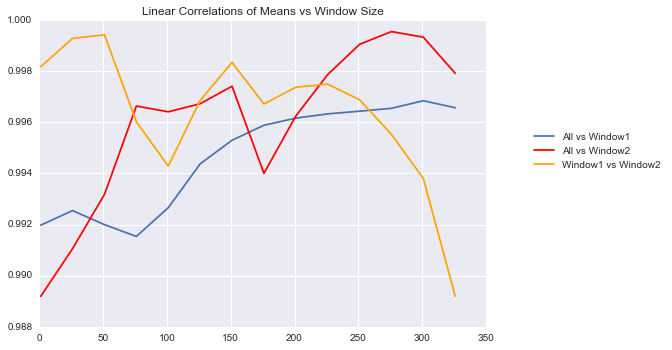

In [140]:
# Let's look at linear correlations of window means for different window sizes and for number of windows is 2.

search = np.arange(1, 350, 25)
nColumns = 7
columns = np.arange(len(search)) % nColumns
all_means = X_train[:, nName:].mean(axis = 1, keepdims = True)

corrs = []
print('windowSize, Correlation of All Mean vs Window Mean 1:')
for var, col in zip(search, columns):
    
    tFeatures = timeFeatures(X_train[:, nName:], var)
    corr_vars = tFeatures.T
    corr_matrix = np.corrcoef(corr_vars)
    corrs.append(corr_matrix)
    print(var, ' ', '%.2f' % corr_matrix[0, 1], ',\t', end = '')
    if col == nColumns - 1:
        print('\n')
        
corrs = np.stack(corrs)
plt.plot(search, corrs[:, 0, 1])
plt.plot(search, corrs[:, 0, 2], color = 'red')
plt.plot(search, corrs[:, 1, 2], color = 'orange')
plt.legend(['All vs Window1', 'All vs Window2', 'Window1 vs Window2'], loc = (1.1, 0.5))
plt.title('Linear Correlations of Means vs Window Size')
plt.show()

So we see that there is high linear correlation between the different window means and the entire mean. This is to be expected, since on average they should all be the same. Therefore, we need to transform our coordinates. The primary coordinate is related to them all being the same.

Window Size, Correlation of All Mean vs Window Mean:
1   0.96 	26   0.90 	51   0.82 	76   0.67 	101   0.65 	126   0.49 	151   0.23 	

176   -0.15 	201   -0.31 	226   -0.33 	251   -0.40 	276   -0.47 	301   -0.55 	326   -0.76 	



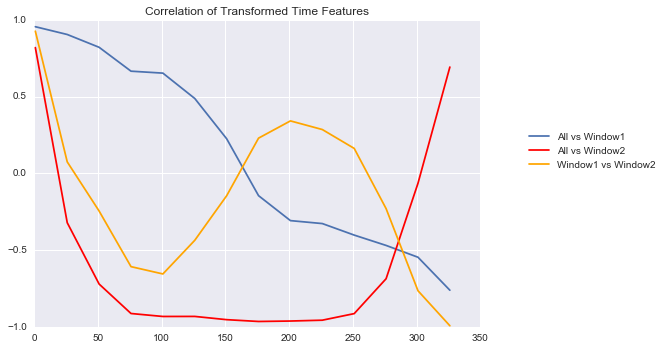

In [141]:
# Define transformation of time features.

def transform_tFeatures(X_means, n_out):
    feature1 = np.mean(X_means, axis = 1)
    feature2 = (X_means[:, 0] - X_means[:, 1]) / np.sqrt(2)
    feature3 = (X_means[:, 0] + X_means[:, 1] - 2 * X_means[:, 2]) / np.sqrt(6)
    features = np.stack([feature1, feature2, feature3], axis = -1)
    return features[:, :n_out]

# Let's look at linear correlations of the transformations as we vary the window size.

search = np.arange(1, 350, 25)
nColumns = 7
columns = np.arange(len(search)) % nColumns
all_means = X_train[:, nName:].mean(axis = 1, keepdims = True)

corrs = []
print('Window Size, Correlation of All Mean vs Window Mean:')
for var, col in zip(search, columns):
    
    tFeatures = timeFeatures(X_train, var)
    tFeatures = transform_tFeatures(tFeatures, 3)
    corr_vars = tFeatures.T
    corr_matrix = np.corrcoef(corr_vars)
    corrs.append(corr_matrix)
    print(var, ' ', '%.2f' % corr_matrix[0, 1], '\t', end = '')
    if col == nColumns - 1:
        print('\n')
        
corrs = np.stack(corrs, axis = -1)
plt.plot(search, corrs[0, 1])
plt.plot(search, corrs[0, 2], color = 'red')
plt.plot(search, corrs[1, 2], color = 'orange')
plt.legend(['All vs Window1', 'All vs Window2', 'Window1 vs Window2'], loc = (1.1, 0.5))
plt.title('Correlation of Transformed Time Features')
plt.show()

It looks like we can't use uniform sizes of windows to minimize linear correlations. We need to use different sizes for each window. Let us investigate these optimal sizes. We will start with the minimizing correlation between all mean and first window mean.

In [142]:
# Now we define our time features to use windows of different sizes.

def timeFeatures2(X, windowSizes):
    
    nSamples, nTimes = X.shape
    nWindows = len(windowSizes)
    stop = nTimes
    features = [X.mean(axis = 1)]
    
    for size in windowSizes:
        features.append(X[:, stop - size : stop].mean(axis = 1))
        stop -= size
        
    features = np.stack(features, axis = -1)
    return features

[WindowSize1, WindowSize2], Correlation All Mean vs Window 1 Mean:
[1, 1]   0.96 	[1, 51]   0.96 	[1, 101]   0.96 	[1, 151]   0.96 	[1, 201]   0.96 	

[1, 251]   0.96 	[1, 301]   0.96 	[1, 351]   0.96 	[1, 401]   0.96 	[1, 451]   0.97 	

[1, 501]   0.97 	[1, 551]   0.97 	[1, 601]   0.97 	[1, 651]   0.97 	[1, 701]   0.97 	

[51, 1]   0.83 	[51, 51]   0.84 	[51, 101]   0.84 	[51, 151]   0.84 	[51, 201]   0.84 	

[51, 251]   0.85 	[51, 301]   0.84 	[51, 351]   0.84 	[51, 401]   0.85 	[51, 451]   0.85 	

[51, 501]   0.85 	[51, 551]   0.85 	[51, 601]   0.86 	[51, 651]   0.86 	[101, 1]   0.70 	

[101, 51]   0.69 	[101, 101]   0.69 	[101, 151]   0.69 	[101, 201]   0.69 	[101, 251]   0.68 	

[101, 301]   0.69 	[101, 351]   0.69 	[101, 401]   0.69 	[101, 451]   0.70 	[101, 501]   0.70 	

[101, 551]   0.70 	[101, 601]   0.70 	[151, 1]   0.31 	[151, 51]   0.32 	[151, 101]   0.32 	

[151, 151]   0.32 	[151, 201]   0.32 	[151, 251]   0.32 	[151, 301]   0.33 	[151, 351]   0.34 	

[151, 401]   0.34 	

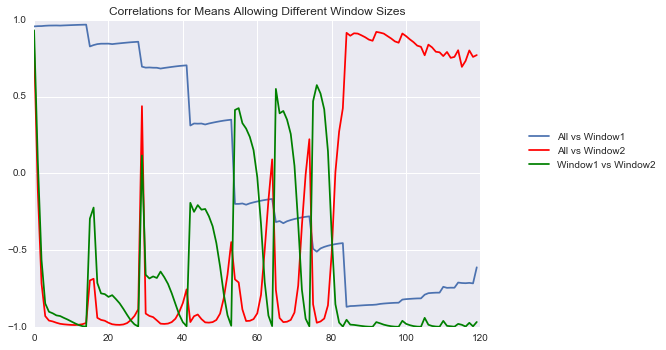

In [143]:
# Let's try searching over both window sizes.

search = np.arange(1, nTimes, 50)
search = [[x, y] for x in search for y in search if x + y < nTimes + 1]

nColumns = 5
columns = np.arange(len(search)) % nColumns
results = []

print('[WindowSize1, WindowSize2], Correlation All Mean vs Window 1 Mean:' )
for sizes, col in zip(search, columns):
    
    tFeatures = timeFeatures2(X_train[:, nName:], sizes)
    tFeatures = transform_tFeatures(tFeatures, 3)
    
    corr_vars = tFeatures.T
    corr_matrix = np.corrcoef(corr_vars)
    results.append(corr_matrix)
    print(sizes, ' ', '%.2f' % corr_matrix[0, 1], '\t', end = '')
    if col == nColumns - 1:
        print('\n')
        
results = np.stack(results, axis = -1)
plt.plot(results[0, 1])
plt.plot(results[0, 2], color = 'red')
plt.plot(results[1, 2], color = 'green')
plt.legend(['All vs Window1', 'All vs Window2', 'Window1 vs Window2'], loc = (1.1, 0.5))
plt.title('Correlations for Means Allowing Different Window Sizes')
plt.show()

Let's use norms of the three linear correlations to determine which should be the best choice to reduce linear correlations between all three features.

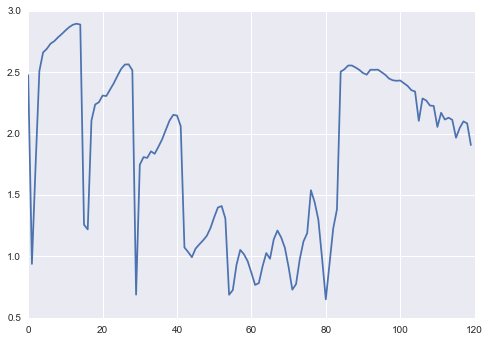

Best are


,windowSize1,windowSize2,normCorrelations
29,101,1,0.688778
54,201,1,0.687703
55,201,51,0.725866
61,201,351,0.767663
62,201,401,0.782689
71,251,301,0.729097
72,251,351,0.774163
80,301,251,0.650375


In [145]:
norms = results[0,2]**2 + results[1,2]**2 + results[0, 1]**2
plt.plot(norms)
plt.show()

search = np.stack(search)
results_df = pd.DataFrame(search, columns = ['windowSize1', 'windowSize2'])
results_df['normCorrelations'] = norms

print('Best are')
results_df[results_df.normCorrelations < 0.8]

Using the magnitude of linear correlations, we see that the optimal window sizes are 201 and 351.

7   92.20 	9   76.74 	11   72.07 	13   70.74 	15   69.56 	17   69.22 	19   69.49 	

21   70.10 	23   71.04 	

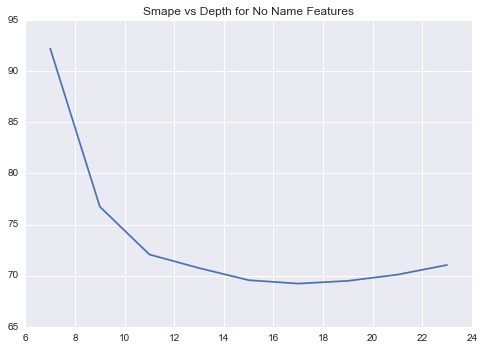

Best depth and smapes are:
[[ 11.          72.06593685]
 [ 13.          70.74242422]
 [ 15.          69.55973715]
 [ 17.          69.22287352]
 [ 19.          69.49124866]
 [ 21.          70.09867445]
 [ 23.          71.04334436]]


In [146]:
# Now we look at a depth first search.

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'windowSizes' : [201, 51]})),
                             ('transform', FunctionTransformer(transform_tFeatures,
                                                              kw_args = {'n_out' : 3}))])

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(7, 25, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for No Name Features')
plt.show()

print('Best depth and smapes are:')
print(np.vstack((search, smapes)).T [smapes < 75])

Now let's do the same for the log transforms.

[1, 1]   -0.01 	[1, 51]   0.04 	[1, 101]   0.05 	[1, 151]   0.06 	[1, 201]   0.07 	

[1, 251]   0.08 	[1, 301]   0.08 	[1, 351]   0.09 	[1, 401]   0.09 	[1, 451]   0.09 	

[1, 501]   0.10 	[1, 551]   0.10 	[1, 601]   0.11 	[1, 651]   0.11 	[1, 701]   0.11 	

[51, 1]   -0.04 	[51, 51]   -0.02 	[51, 101]   -0.00 	[51, 151]   0.01 	[51, 201]   0.02 	

[51, 251]   0.03 	[51, 301]   0.03 	[51, 351]   0.04 	[51, 401]   0.04 	[51, 451]   0.05 	

[51, 501]   0.05 	[51, 551]   0.06 	[51, 601]   0.06 	[51, 651]   0.06 	[101, 1]   -0.05 	

[101, 51]   -0.03 	[101, 101]   -0.01 	[101, 151]   -0.00 	[101, 201]   0.01 	[101, 251]   0.02 	

[101, 301]   0.02 	[101, 351]   0.03 	[101, 401]   0.03 	[101, 451]   0.04 	[101, 501]   0.04 	

[101, 551]   0.04 	[101, 601]   0.05 	[151, 1]   -0.10 	[151, 51]   -0.07 	[151, 101]   -0.05 	

[151, 151]   -0.04 	[151, 201]   -0.03 	[151, 251]   -0.03 	[151, 301]   -0.02 	[151, 351]   -0.02 	

[151, 401]   -0.01 	[151, 451]   -0.01 	[151, 501]   -0.01 	[151, 551]

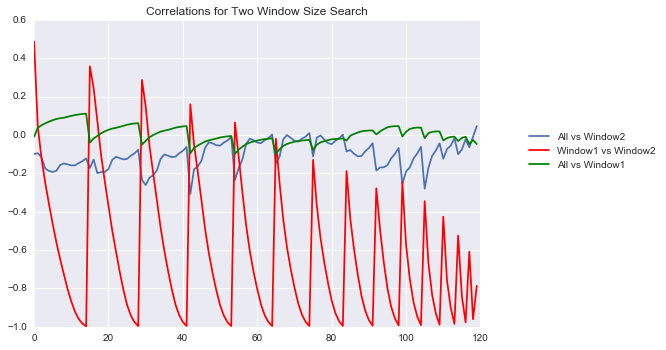

In [81]:
# Let's try searching over both window sizes when including log transform.

param = 300
search = np.arange(1, nTimes, 50)
search = [[x, y] for x in search for y in search if x + y < nTimes + 1]

nColumns = 5
columns = np.arange(len(search)) % nColumns
results = []

Z_train = np.log(param + X_train[:, nName:])
for sizes, col in zip(search, columns):
    
    tFeatures = timeFeatures2(Z_train, sizes)
    tFeatures = transform_tFeatures(tFeatures, 3)
    
    corr_vars = tFeatures.T
    corr_matrix = np.corrcoef(corr_vars)
    results.append(corr_matrix)
    print(sizes, ' ', '%.2f' % corr_matrix[0, 1], '\t', end = '')
    if col == nColumns - 1:
        print('\n')
        
results = np.stack(results, axis = -1)
plt.plot(results[0, 2])
plt.plot(results[1, 2], color = 'red')
plt.plot(results[0, 1], color = 'green')
plt.title('Correlations for Two Window Size Search')
plt.legend(['All vs Window2', 'Window1 vs Window2', 'All vs Window1'], loc = (1.1, 0.5))
plt.show()

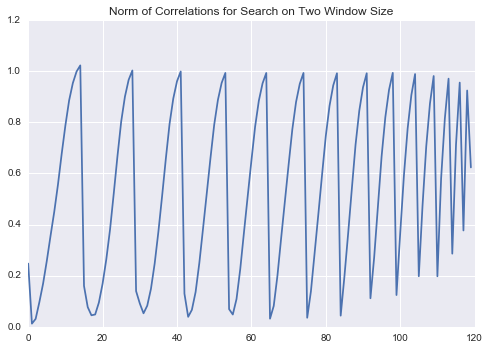

,windowSize1,windowSize2,norm,totalsize
3,1,151,0.096309,152
17,51,101,0.044999,152
18,51,151,0.048181,202
19,51,201,0.094743,252
30,101,51,0.091268,152
31,101,101,0.052740,202
32,101,151,0.082576,252
43,151,51,0.039003,202
44,151,101,0.066332,252
54,201,1,0.069073,202


In [82]:
norms = results[0,2]**2 + results[1,2]**2 + results[0, 1]**2
plt.plot(norms)
plt.title('Norm of Correlations for Search on Two Window Size')
plt.show()

search = np.stack(search)
results_df = pd.DataFrame(search, columns = ['windowSize1', 'windowSize2'])
results_df['norm'] = norms
results_df['totalsize'] = results_df.windowSize1 + results_df.windowSize2

results_df[(results_df.norm < 0.1) & (results_df.totalsize > 150)]

7   63.26 	9   61.83 	11   61.26 	13   61.68 	15   63.01 	17   65.12 	19   67.59 	

21   70.47 	23   73.08 	

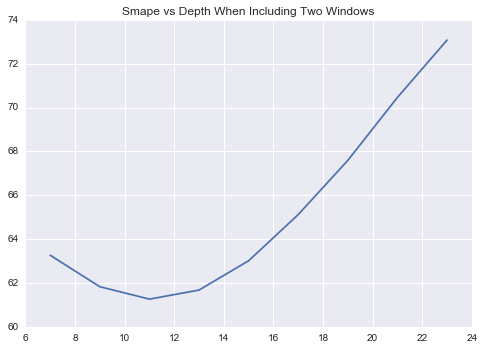

Best depth and smapes are:


,depth,smapes
1,9,61.827922
2,11,61.262144
3,13,61.676909


In [87]:
# Now we look at a depth first search.
param = 300
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'windowSizes' : [51, 151]})),
                             ('transform', FunctionTransformer(transform_tFeatures,
                                                              kw_args = {'n_out' : 3}))])

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(7, 25, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

Z_train = np.log(param + Y_train)
for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth When Including Two Windows')
plt.show()

print('Best depth and smapes are:')
results_df = pd.DataFrame(search, columns = ['depth'])
results_df['smapes'] = smapes

results_df[results_df.smapes < 63]